[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Khipucamayoc/Quipucamayoc/blob/master/colabs/TTS_NVIDIA_Tacotron2_es_AR.ipynb)

### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------




In [ ]:
%tensorflow_version 1.x

In [ ]:
%%time
%%bash
git clone https://github.com/NVIDIA/apex
cd apex
pip install  --no-cache-dir ./ # only python  

Processing /content/tacotron2/apex
  Created wheel for apex: filename=apex-0.1-cp36-none-any.whl size=177174 sha256=ed6437ca14955b637a297e2ac03e7385aafcc5f5a72036a8145d3eab2dca3eb0
  Stored in directory: /tmp/pip-ephem-wheel-cache-cmtur7wi/wheels/01/a3/0e/a8c8f0aef8803c8a9e760b007530c5797ca0db443af11d6a76
Successfully built apex
  Found existing installation: apex 0.1
    Uninstalling apex-0.1:
      Successfully uninstalled apex-0.1


Cloning into 'apex'...


CPU times: user 5.05 ms, sys: 29.2 ms, total: 34.2 ms
Wall time: 7.05 s


In [ ]:
%%bash
git clone https://github.com/NVIDIA/tacotron2.git
cd tacotron2/
git submodule init
git submodule update

Submodule path 'waveglow': checked out '2fd4e63e2918012f55eac2c8a8e75622a39741be'


Cloning into 'tacotron2'...
Submodule 'waveglow' (https://github.com/NVIDIA/waveglow) registered for path 'waveglow'
Cloning into '/content/tacotron2/tacotron2/waveglow'...


When you run the next field, you will be prompted to click on a link, sign in to your Google account, and agree to permissions. Copy the resulting key and paste into the field.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# downloaded = drive.CreateFile({'id':"1fqsBwoX-HM6-0sF2nH6o1foxd4F6qrGh"})
# checkpoint_path = "/content/checkpoint_232000"

downloaded = drive.CreateFile({'id':"1WH_iFXb8oMcDqhpHBNOY5t0lzui6ctaB"})
checkpoint_path = "/content/checkpoint_215000"

# downloaded = drive.CreateFile({'id':"1Wt8QrDaj2UyGvkoAAsp4e81ccmc7LGyq"})
# checkpoint_path = "/content/checkpoint_138000"

downloaded.GetContentFile(checkpoint_path)


In [ ]:
!pip install unidecode

In [ ]:
import os
import torch
os.chdir('tacotron2')
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
import numpy as np

import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd
%matplotlib inline

In [ ]:
!wget https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/3/files/waveglow_256channels_ljs_v3.pt

--2020-05-15 00:47:31--  https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/3/files/waveglow_256channels_ljs_v3.pt
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 54.153.26.224, 54.241.185.37
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|54.153.26.224|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://s3.us-west-2.amazonaws.com/prod-model-registry-ngc-bucket/org/nvidia/models/waveglow_ljs_256channels/versions/3/files/waveglow_256channels_ljs_v3.pt?response-content-disposition=attachment%3B%20filename%3D%22waveglow_256channels_ljs_v3.pt%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEDcaCXVzLXdlc3QtMSJGMEQCIHZalOVgD3eZiX2OF0C2QRGnl%2FRqdjlFb2YeooGnDb67AiBkX0q8Rqu%2BcMwz%2BdYGiCwPJgCxS8pxLyeKc7pvcuvfWCq9AwiA%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F8BEAIaDDc4OTM2MzEzNTAyNyIMk0jBHIN8W2gKLsVlKpED5Iv1aEHrGL993rKDHu%2FvjyXdjZM9KNVr%2BIlgyZiC4YHsg%2BFBNP6y7EiTkka9i2HY3NM4DB%2FySOoc5GVaiUlhRwZ1

In [ ]:
# OLD MODEL
# waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')
# waveglow = waveglow.remove_weightnorm(waveglow)
# waveglow = waveglow.to('cuda')
# waveglow.train()

import sys
sys.path.append('waveglow/')
from denoiser import Denoiser

waveglow_path = '/content/tacotron2/waveglow_256channels_ljs_v3.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow = waveglow.remove_weightnorm(waveglow)
#waveglow.cuda().eval().half() # Removed due to error: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same
waveglow = waveglow.to('cuda')
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow).cuda()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

In [ ]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [ ]:
hparams = create_hparams("distributed_run=False,mask_padding=False")
hparams.sampling_rate = 22050
hparams.filter_length = 1024
hparams.hop_length = 256
hparams.win_length = 1024
hparams.n_symbols = 162 # 148 in english + 14 spanish symbols

INFO:tensorflow:Parsing command line hparams: distributed_run=False,mask_padding=False


In [ ]:
import re

_pad        = '_'
_punctuation = '¡¿!\'(),.:;? '
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz' + 'ñáéíóúÁÉÍÓÚÑ'

_whitespace_re = re.compile(r'\s+')

# Export all symbols:
symbols = [_pad] + list(_special) + list(_punctuation) + list(_letters)

_symbol_to_id = {s: i for i, s in enumerate(symbols)}
_id_to_symbol = {i: s for i, s in enumerate(symbols)}

_abbreviations_es = [(re.compile('\\b%s\\.' % x[0], re.IGNORECASE), x[1]) for x in [
  ('srta', 'señorita'),
  ('sra', 'señora'),
  ('sr', 'señor'),
  ('dr', 'doctor'),
  ('sto', 'santo'),
  ('sta', 'santa'),
  ('cía', 'compañía'),
  ('jr', 'junior'),
]]

def _should_keep_symbol(s):
  return s in _symbol_to_id and s is not '_' and s is not '~'

def _symbols_to_sequence(symbols):
  return [_symbol_to_id[s] for s in symbols if _should_keep_symbol(s)]

def collapse_whitespace(text):
  return re.sub(_whitespace_re, ' ', text)

def expand_abbreviations_es(text):
  for regex, replacement in _abbreviations_es:
    text = re.sub(regex, replacement, text)
  return text

def lowercase(text):
  return text.lower()

def es_cleaners(text):
  '''Spanish pipeline that replaces abbreviations, lowercases and collapses whitespace without transliteration.'''
  text = lowercase(text)
  text = expand_abbreviations_es(text)
  text = collapse_whitespace(text)
  return text

def _clean_text(text):
  text = es_cleaners(text)
  return text

def text_to_sequence_es(text):
  return _symbols_to_sequence(_clean_text(text))

In [ ]:
model = load_model(hparams)
try:
    model = model.module
except:
    pass
model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(checkpoint_path)['state_dict'].items()})
_ = model.train()

In [ ]:
#text = "El poema de estar en mí. Esta mañana dentro los ojos con un tiempo sin nombre, y me sentía, un poema y mi corazón."
#text = "Ciencia Oye al sol del cielo. Ya todo es ciencia. Haz que se me abandona. No más a qué es tu noche que no es más, tu ciencia."
#text = 'He contado al lector todo cuanto sabía: era un deber para mí.'
#text = 'prueba de que el alma solo concibe santos pensamientos y de que los labios no dicen mas que palabras piadosas.'
#text = 'Hola Parag Kenric y Paola espero que estén bien durante esta cuarentena.'
text = "Cada parcialidad tiene regularmente, cada mes, sus propias sesiones de orden en la casa del presidente. "

sequence = np.array(text_to_sequence_es(text))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
print(sequence)

tensor([[42, 40, 43, 40, 13, 55, 40, 57, 42, 48, 40, 51, 48, 43, 40, 43, 13, 59,
         48, 44, 53, 44, 13, 57, 44, 46, 60, 51, 40, 57, 52, 44, 53, 59, 44,  8,
         13, 42, 40, 43, 40, 13, 52, 44, 58,  8, 13, 58, 60, 58, 13, 55, 57, 54,
         55, 48, 40, 58, 13, 58, 44, 58, 48, 54, 53, 44, 58, 13, 43, 44, 13, 54,
         57, 43, 44, 53, 13, 44, 53, 13, 51, 40, 13, 42, 40, 58, 40, 13, 43, 44,
         51, 13, 55, 57, 44, 58, 48, 43, 44, 53, 59, 44,  9, 13]],
       device='cuda:0')


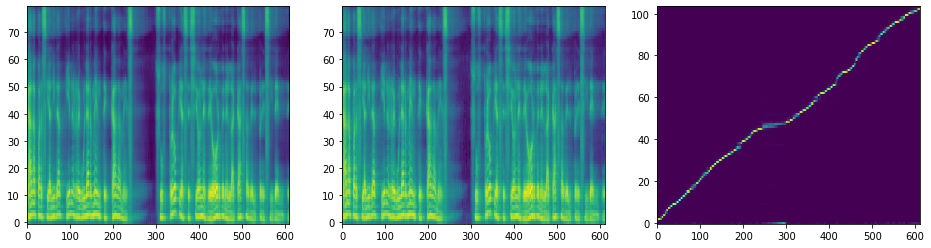

In [ ]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))


In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
audio = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)